In [20]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

sys.path.append('..')

In [21]:
from src.data import get_mnist_dataset, create_data_loaders, subsample_dataset
from src.models import get_vae_model, get_dvae_model
from src.utils.training import Trainer
from src.utils.visualization import visualize_noise_examples, visualize_reconstructions, visualize_generated_samples, visualize_latent_space

In [22]:
data_dir = '../data'
save_dir = '../results/notebook_demo'
os.makedirs(save_dir, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [23]:
noise_type = 'gaussian'
noise_params = {
    'noise_factor': 0.5,
    'clip_min': 0.0,
    'clip_max': 1.0
}


subsample_size = 5000
train_dataset_clean = get_mnist_dataset(
    root=data_dir,
    train=True,
    download=True
)
train_dataset_noisy = get_mnist_dataset(
    root=data_dir,
    train=True,
    noise_type=noise_type,
    noise_params=noise_params,
    download=True
)
test_dataset_clean = get_mnist_dataset(
    root=data_dir,
    train=False,
    download=True
)       
test_dataset_noisy = get_mnist_dataset(
    root=data_dir,
    train=False,
    noise_type=noise_type,
    noise_params=noise_params,
    download=True
)

In [24]:

if subsample_size > 0:
    train_dataset_clean = subsample_dataset(train_dataset_clean, subsample_size, stratified=True)
    train_dataset_noisy = subsample_dataset(train_dataset_noisy, subsample_size, stratified=True)
    print(f"Subsampled training datasets to {len(train_dataset_clean)} examples")

batch_size = 64
train_loader_clean, val_loader_clean = create_data_loaders(
    train_dataset_clean,
    batch_size=batch_size,
    val_split=0.1,
    shuffle=True,
    num_workers=2
)
train_loader_noisy, val_loader_noisy = create_data_loaders(
    train_dataset_noisy,
    batch_size=batch_size,
    val_split=0.1,
    shuffle=True,
    num_workers=2
)
test_loader_clean, _ = create_data_loaders(
    test_dataset_clean,
    batch_size=batch_size,
    val_split=0.0,
    shuffle=False,
    num_workers=2
)
test_loader_noisy, _ = create_data_loaders(
    test_dataset_noisy,
    batch_size=batch_size,
    val_split=0.0,
    shuffle=False,
    num_workers=2
)

Subsampled training datasets to 5000 examples


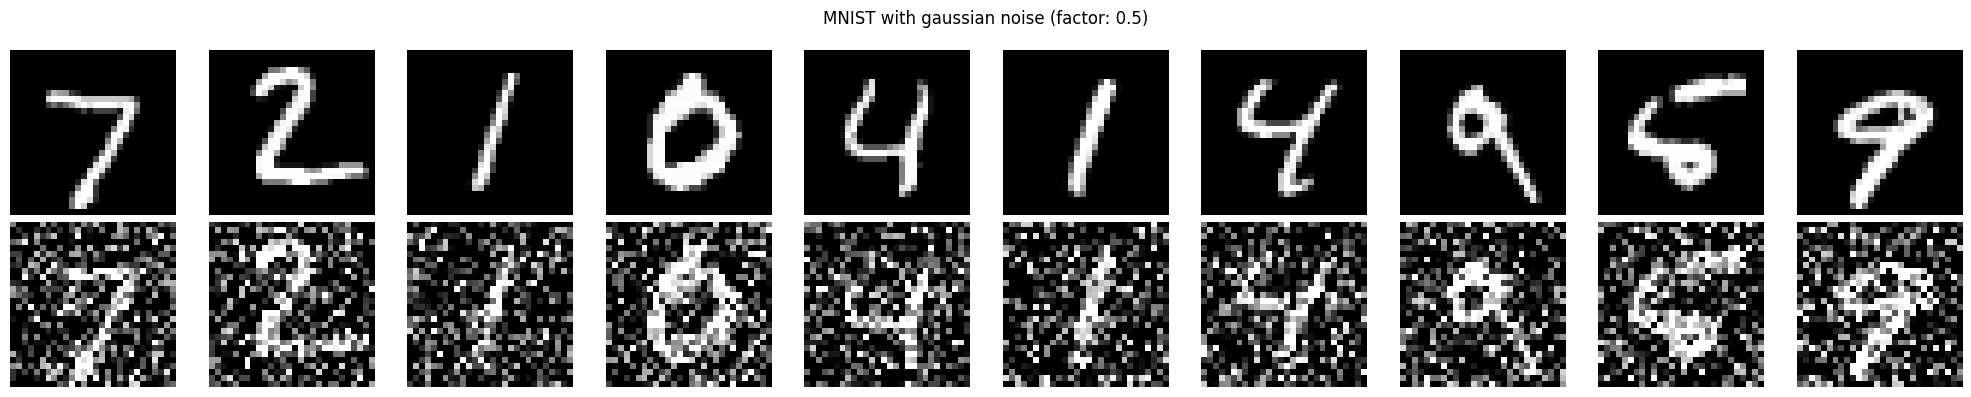

In [25]:
batch_noisy = next(iter(test_loader_noisy))
noisy_imgs, clean_imgs, labels = batch_noisy
fig = visualize_noise_examples(
    clean_imgs[:10],
    noisy_imgs[:10],
    num_examples=10,
    title=f"MNIST with {noise_type} noise (factor: {noise_params['noise_factor']})"
)
plt.show()

In [27]:
vae_model = get_vae_model(
    img_channels=1,
    img_size=28,
    hidden_dims=[32, 64, 128],  # Smaller network for faster training
    latent_dim=16,
    kl_weight=1.0
)

vae_trainer = Trainer(
    model=vae_model,
    train_loader=train_loader_clean,
    val_loader=val_loader_clean,
    device=device,
    save_dir=save_dir,
    experiment_name='vae_demo'
)

vae_trainer.train(
    num_epochs=20,
    early_stopping=False,
    save_best_only=True
)


Note: Architecture will produce 24x24 images, but target is 28x28. Will use interpolation if needed.
Training VAE for 20 epochs
Device: cuda


Epoch 1:  18%|█▊        | 13/71 [00:00<00:01, 39.00batch/s, loss=109, recon=105, kl=3.29]

Input shape: torch.Size([64, 1, 28, 28]), Feature shape: torch.Size([64, 128, 4, 4])
Resizing output from torch.Size([24, 24]) to target 28x28


Epoch 1: 100%|██████████| 71/71 [00:01<00:00, 66.35batch/s, loss=59.9, recon=57.2, kl=2.77]


Epoch 1/20 - Train Loss: 87.8763, Val Loss: 58.8710


Epoch 2: 100%|██████████| 71/71 [00:01<00:00, 69.13batch/s, loss=43, recon=37.3, kl=5.69]  


Epoch 2/20 - Train Loss: 50.6274, Val Loss: 45.6698


Epoch 3: 100%|██████████| 71/71 [00:01<00:00, 66.79batch/s, loss=40.6, recon=33.5, kl=7.1] 


Epoch 3/20 - Train Loss: 42.4016, Val Loss: 40.9092


Epoch 4: 100%|██████████| 71/71 [00:01<00:00, 64.90batch/s, loss=37.6, recon=30, kl=7.62]  


Epoch 4/20 - Train Loss: 38.8885, Val Loss: 38.9430


Epoch 5: 100%|██████████| 71/71 [00:01<00:00, 67.41batch/s, loss=34.9, recon=26.2, kl=8.71]


Epoch 5/20 - Train Loss: 37.2241, Val Loss: 37.0763


Epoch 6: 100%|██████████| 71/71 [00:01<00:00, 68.87batch/s, loss=33.6, recon=24.3, kl=9.26]


Epoch 6/20 - Train Loss: 35.9322, Val Loss: 36.5886


Epoch 7: 100%|██████████| 71/71 [00:01<00:00, 66.49batch/s, loss=40.4, recon=30.6, kl=9.77]


Epoch 7/20 - Train Loss: 34.9579, Val Loss: 35.5070


Epoch 8: 100%|██████████| 71/71 [00:01<00:00, 69.56batch/s, loss=37.5, recon=27.2, kl=10.3]


Epoch 8/20 - Train Loss: 34.3326, Val Loss: 35.3398


Epoch 9: 100%|██████████| 71/71 [00:01<00:00, 68.63batch/s, loss=35.9, recon=26.1, kl=9.81]


Epoch 9/20 - Train Loss: 33.6346, Val Loss: 34.2336


Epoch 10: 100%|██████████| 71/71 [00:01<00:00, 67.43batch/s, loss=30.6, recon=20.6, kl=9.98]


Epoch 10/20 - Train Loss: 33.3437, Val Loss: 34.1486


Epoch 11: 100%|██████████| 71/71 [00:01<00:00, 66.78batch/s, loss=33, recon=22.5, kl=10.5]  


Epoch 11/20 - Train Loss: 32.9328, Val Loss: 34.0731


Epoch 12: 100%|██████████| 71/71 [00:01<00:00, 66.62batch/s, loss=33, recon=22.4, kl=10.6]  


Epoch 12/20 - Train Loss: 32.6711, Val Loss: 33.4885


Epoch 13: 100%|██████████| 71/71 [00:01<00:00, 66.37batch/s, loss=32.1, recon=21.6, kl=10.6]


Epoch 13/20 - Train Loss: 32.3574, Val Loss: 33.2763


Epoch 14: 100%|██████████| 71/71 [00:01<00:00, 64.34batch/s, loss=31, recon=20.1, kl=10.9]  


Epoch 14/20 - Train Loss: 32.1093, Val Loss: 33.1009


Epoch 15: 100%|██████████| 71/71 [00:01<00:00, 69.18batch/s, loss=34.5, recon=23.4, kl=11.1]


Epoch 15/20 - Train Loss: 31.9456, Val Loss: 32.9790


Epoch 16: 100%|██████████| 71/71 [00:01<00:00, 66.90batch/s, loss=29.1, recon=18.5, kl=10.6]


Epoch 16/20 - Train Loss: 31.6151, Val Loss: 32.8241


Epoch 17: 100%|██████████| 71/71 [00:01<00:00, 65.70batch/s, loss=30.6, recon=19.6, kl=11.1]


Epoch 17/20 - Train Loss: 31.6735, Val Loss: 32.7409


Epoch 18: 100%|██████████| 71/71 [00:01<00:00, 68.09batch/s, loss=32.9, recon=21.6, kl=11.3]


Epoch 18/20 - Train Loss: 31.4046, Val Loss: 32.5874


Epoch 19: 100%|██████████| 71/71 [00:01<00:00, 64.97batch/s, loss=31.8, recon=20.9, kl=10.9]


Epoch 19/20 - Train Loss: 31.2269, Val Loss: 32.8194


Epoch 20: 100%|██████████| 71/71 [00:01<00:00, 67.84batch/s, loss=32.8, recon=21.7, kl=11.1]


Epoch 20/20 - Train Loss: 31.1142, Val Loss: 32.2638


{'train_losses': {'total': [87.87634535047744,
   50.62738665093316,
   42.40159475368924,
   38.88848342556424,
   37.22405050998264,
   35.93223555501302,
   34.95787871636285,
   34.3325810546875,
   33.63458726671007,
   33.34374896918403,
   32.932811564127604,
   32.67114686414931,
   32.35738511827257,
   32.10934152560764,
   31.945574055989585,
   31.615068074544272,
   31.673521647135416,
   31.404622341579863,
   31.226908393012152,
   31.114168836805554],
  'recon': [85.42131852213542,
   46.353598958333336,
   35.94835316297743,
   31.174555541992188,
   28.77711454264323,
   26.926325656467014,
   25.566061631944443,
   24.64707855902778,
   23.690771158854165,
   23.13704977077908,
   22.50875887722439,
   22.17298527018229,
   21.71567097981771,
   21.33439318847656,
   21.05500109863281,
   20.73905963812934,
   20.644100124782987,
   20.31726357014974,
   20.122396497938368,
   19.99330760362413],
  'kl': [2.455026845296224,
   4.273787575615777,
   6.453241753472223,

In [28]:
dvae_model = get_dvae_model(
    img_channels=1,
    img_size=28,
    hidden_dims=[32, 64, 128],  # Same architecture as VAE for fair comparison
    latent_dim=16,
    kl_weight=1.0
)

dvae_trainer = Trainer(
    model=dvae_model,
    train_loader=train_loader_noisy,
    val_loader=val_loader_noisy,
    device=device,
    save_dir=save_dir,
    experiment_name='dvae_demo'
)

dvae_trainer.train(
    num_epochs=20,
    early_stopping=False,
    save_best_only=True
)   

Note: Architecture will produce 24x24 images, but target is 28x28. Will use interpolation if needed.
Training DVAE for 20 epochs
Device: cuda


Epoch 1:  17%|█▋        | 12/71 [00:00<00:01, 36.96batch/s, loss=746, recon=735, kl=10.9]       

Input shape: torch.Size([64, 1, 28, 28]), Feature shape: torch.Size([64, 128, 4, 4])
Resizing output from torch.Size([24, 24]) to target 28x28


Epoch 1: 100%|██████████| 71/71 [00:01<00:00, 62.68batch/s, loss=382, recon=377, kl=5.24]


Epoch 1/20 - Train Loss: 581.4012, Val Loss: 400.0398


Epoch 2: 100%|██████████| 71/71 [00:01<00:00, 63.60batch/s, loss=277, recon=268, kl=9.52]


Epoch 2/20 - Train Loss: 325.7467, Val Loss: 258.5505


Epoch 3: 100%|██████████| 71/71 [00:01<00:00, 64.91batch/s, loss=198, recon=186, kl=12.9]


Epoch 3/20 - Train Loss: 215.7581, Val Loss: 187.8091


Epoch 4: 100%|██████████| 71/71 [00:01<00:00, 65.91batch/s, loss=159, recon=144, kl=15.7]


Epoch 4/20 - Train Loss: 177.9892, Val Loss: 168.4350


Epoch 5: 100%|██████████| 71/71 [00:01<00:00, 63.76batch/s, loss=151, recon=134, kl=16.5]


Epoch 5/20 - Train Loss: 162.2326, Val Loss: 155.9755


Epoch 6: 100%|██████████| 71/71 [00:01<00:00, 61.61batch/s, loss=140, recon=123, kl=17.4]


Epoch 6/20 - Train Loss: 152.8809, Val Loss: 149.3193


Epoch 7: 100%|██████████| 71/71 [00:01<00:00, 64.35batch/s, loss=151, recon=134, kl=17.7]


Epoch 7/20 - Train Loss: 146.7350, Val Loss: 144.6665


Epoch 8: 100%|██████████| 71/71 [00:01<00:00, 62.34batch/s, loss=149, recon=130, kl=19]  


Epoch 8/20 - Train Loss: 142.3110, Val Loss: 140.5591


Epoch 9: 100%|██████████| 71/71 [00:01<00:00, 65.47batch/s, loss=146, recon=127, kl=19]  


Epoch 9/20 - Train Loss: 138.8429, Val Loss: 138.6178


Epoch 10: 100%|██████████| 71/71 [00:01<00:00, 64.46batch/s, loss=134, recon=114, kl=20.3]


Epoch 10/20 - Train Loss: 135.9830, Val Loss: 137.6107


Epoch 11: 100%|██████████| 71/71 [00:01<00:00, 64.59batch/s, loss=137, recon=116, kl=20.2]


Epoch 11/20 - Train Loss: 133.6280, Val Loss: 135.4405


Epoch 12: 100%|██████████| 71/71 [00:01<00:00, 65.26batch/s, loss=132, recon=111, kl=20.9]


Epoch 12/20 - Train Loss: 132.2365, Val Loss: 131.9961


Epoch 13: 100%|██████████| 71/71 [00:01<00:00, 63.51batch/s, loss=115, recon=94.3, kl=20.6]


Epoch 13/20 - Train Loss: 130.5274, Val Loss: 130.9734


Epoch 14: 100%|██████████| 71/71 [00:01<00:00, 61.64batch/s, loss=145, recon=123, kl=21.6]


Epoch 14/20 - Train Loss: 129.2711, Val Loss: 131.1322


Epoch 15: 100%|██████████| 71/71 [00:01<00:00, 64.79batch/s, loss=114, recon=92.5, kl=21.1]


Epoch 15/20 - Train Loss: 128.1753, Val Loss: 129.8782


Epoch 16: 100%|██████████| 71/71 [00:01<00:00, 63.54batch/s, loss=137, recon=116, kl=21.1] 


Epoch 16/20 - Train Loss: 127.2620, Val Loss: 128.6288


Epoch 17: 100%|██████████| 71/71 [00:01<00:00, 62.03batch/s, loss=132, recon=111, kl=21.4] 


Epoch 17/20 - Train Loss: 126.1259, Val Loss: 128.2880


Epoch 18: 100%|██████████| 71/71 [00:01<00:00, 61.21batch/s, loss=114, recon=92, kl=22]    


Epoch 18/20 - Train Loss: 125.2853, Val Loss: 127.1072


Epoch 19: 100%|██████████| 71/71 [00:01<00:00, 65.22batch/s, loss=129, recon=107, kl=21.9] 


Epoch 19/20 - Train Loss: 124.3670, Val Loss: 126.2576


Epoch 20: 100%|██████████| 71/71 [00:01<00:00, 63.50batch/s, loss=122, recon=99.9, kl=21.8]


Epoch 20/20 - Train Loss: 124.2336, Val Loss: 126.2565


{'train_losses': {'total': [581.4011946614584,
   325.7467236328125,
   215.7581240234375,
   177.98923187934028,
   162.23259217664932,
   152.8808972439236,
   146.7349990234375,
   142.3109638671875,
   138.8428929578993,
   135.98304774305555,
   133.6279974500868,
   132.23646929253474,
   130.52739995659724,
   129.2710650499132,
   128.17529052734375,
   127.26200406901042,
   126.12593044704862,
   125.28531608072916,
   124.36699262152777,
   124.2336413845486],
  'recon': [574.8511156684028,
   318.41825575086807,
   204.27333544921876,
   163.78588406032986,
   146.34558355034721,
   135.79335850694446,
   128.80186637369792,
   123.73248019748264,
   119.6998025173611,
   116.39134499782986,
   113.67425661892361,
   111.95187234157986,
   109.90373627387153,
   108.3483859592014,
   107.10562459309895,
   106.10274685329861,
   104.81286512586806,
   103.79903754340278,
   102.77515516493055,
   102.44868760850694],
  'kl': [6.550081251356337,
   7.328468770345052,
   11.4

Noisy input PSNR: 9.35 dB
VAE reconstruction PSNR: 11.93 dB (improvement: 2.58 dB)
DVAE reconstruction PSNR: 16.33 dB (improvement: 6.98 dB)


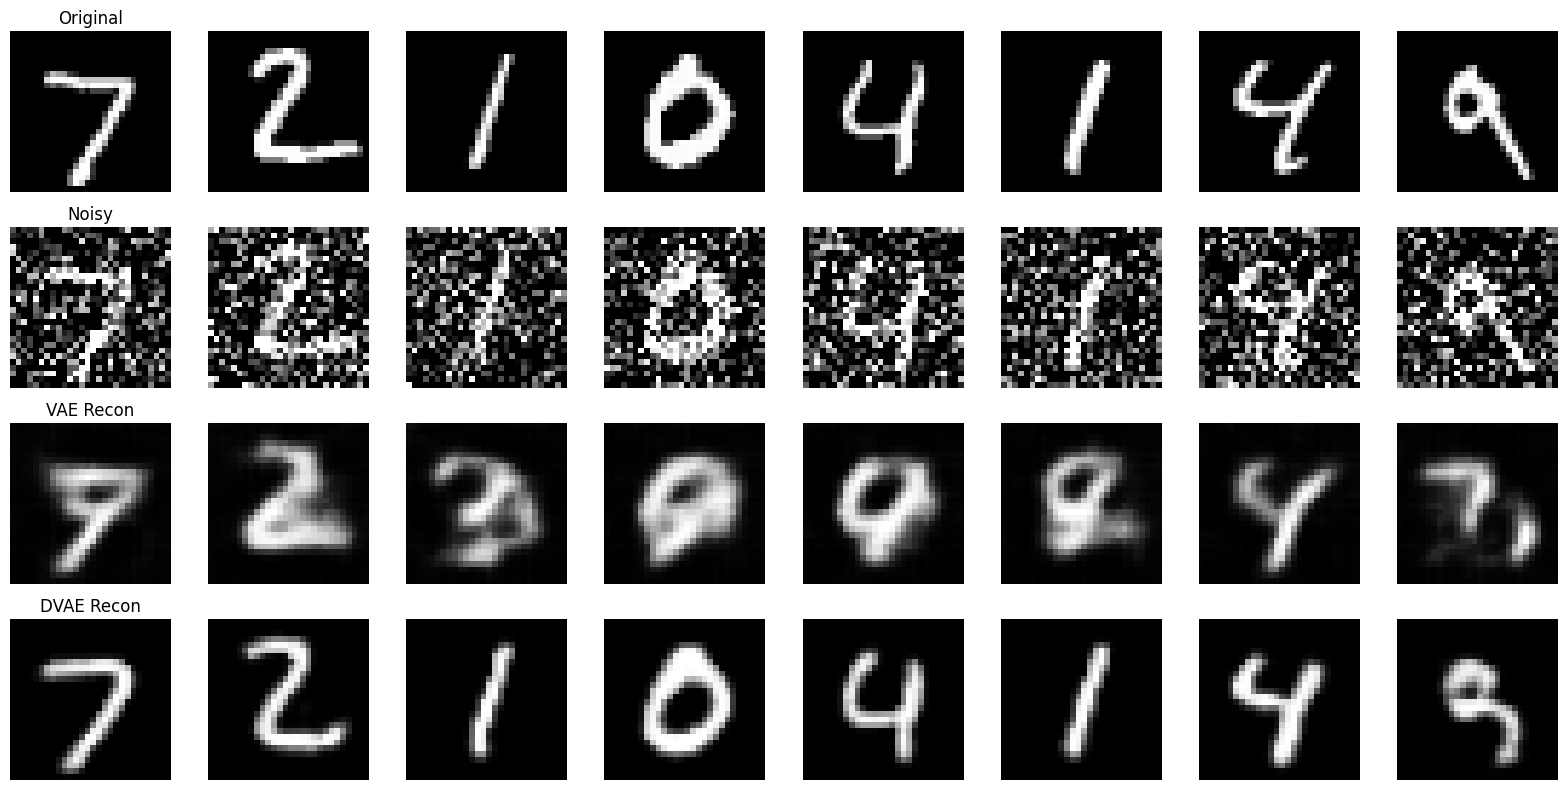

In [29]:
batch = next(iter(test_loader_noisy))
noisy_imgs, clean_imgs, _ = batch       

noisy_imgs = noisy_imgs.to(device)
clean_imgs = clean_imgs.to(device)

with torch.no_grad():
    vae_recon, _, _ = vae_model(noisy_imgs)
    dvae_recon, _, _ = dvae_model(noisy_imgs)

#Compute PSNR
from src.utils.training import compute_psnr
noisy_psnr = compute_psnr(clean_imgs, noisy_imgs)
vae_psnr = compute_psnr(clean_imgs, vae_recon)
dvae_psnr = compute_psnr(clean_imgs, dvae_recon)

print(f"Noisy input PSNR: {noisy_psnr:.2f} dB")
print(f"VAE reconstruction PSNR: {vae_psnr:.2f} dB (improvement: {vae_psnr - noisy_psnr:.2f} dB)")
print(f"DVAE reconstruction PSNR: {dvae_psnr:.2f} dB (improvement: {dvae_psnr - noisy_psnr:.2f} dB)")

#Visualize examples
n_examples = 8

fig, axes = plt.subplots(4, n_examples, figsize=(n_examples*2, 8))

clean_imgs_cpu = clean_imgs[:n_examples].cpu()
noisy_imgs_cpu = noisy_imgs[:n_examples].cpu()
vae_recon_cpu = vae_recon[:n_examples].cpu()
dvae_recon_cpu = dvae_recon[:n_examples].cpu()

for i in range(n_examples):
    #Original images
    axes[0, i].imshow(clean_imgs_cpu[i].squeeze(0), cmap='gray')
    if i == 0:
        axes[0, i].set_title('Original')
    axes[0, i].axis('off')
    
    #Noisy images
    axes[1, i].imshow(noisy_imgs_cpu[i].squeeze(), cmap='gray')
    if i == 0:
        axes[1, i].set_title('Noisy')
    axes[1, i].axis('off')

    axes[2, i].imshow(vae_recon_cpu[i].squeeze(0), cmap='gray')
    if i == 0:
        axes[2, i].set_title('VAE Recon')
    axes[2, i].axis('off')
    
    axes[3, i].imshow(dvae_recon_cpu[i].squeeze(0), cmap='gray')
    if i == 0:
        axes[3, i].set_title('DVAE Recon')
    axes[3, i].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'reconstruction_comparison.png'))
plt.show()


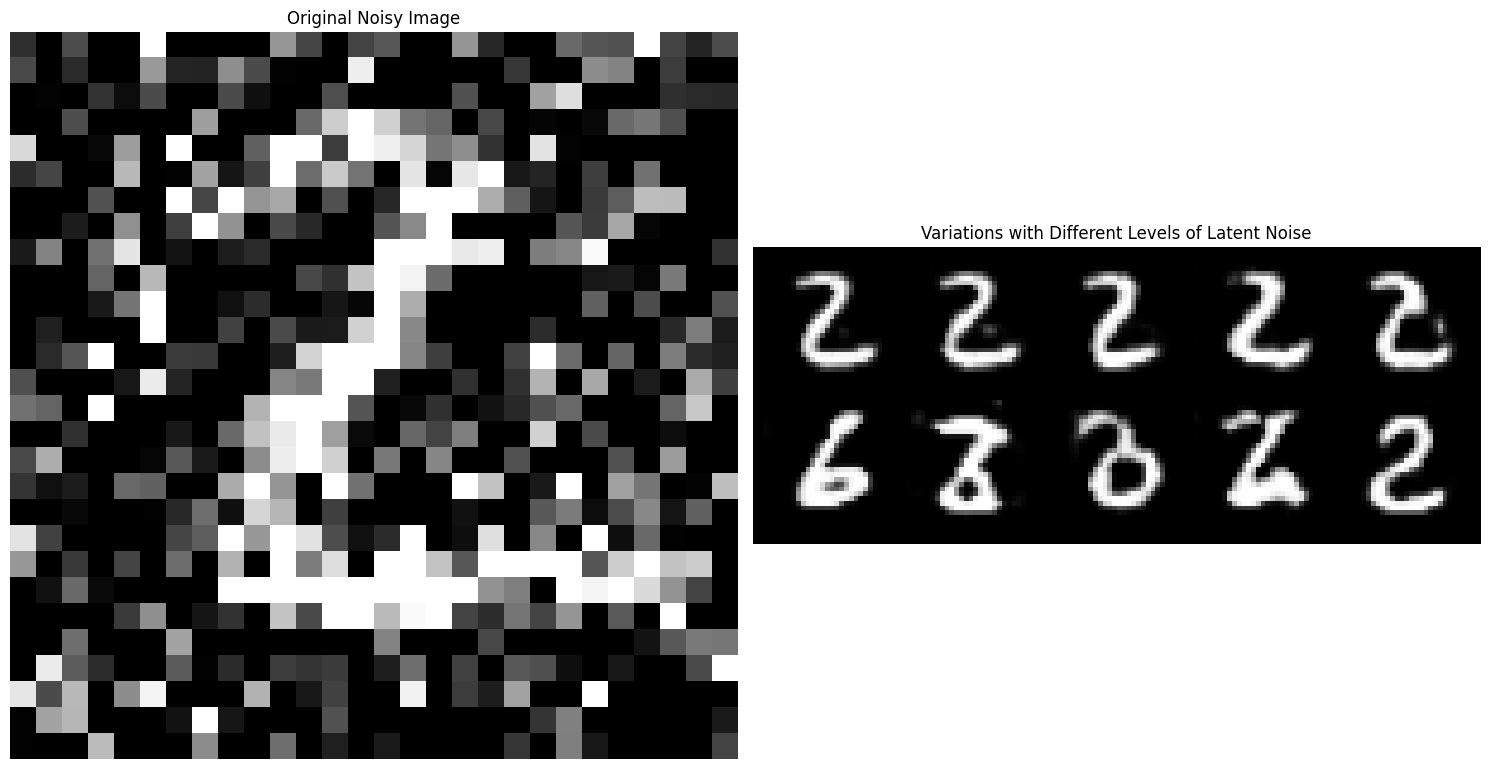

In [41]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

# Set the model to evaluation mode
dvae_model.eval()

# 1. Get a batch of noisy images from your test set
test_batch = next(iter(test_loader_noisy))
if len(test_batch) == 3:  # If using NoisyDataset with (noisy, clean, label) format
    noisy_imgs, clean_imgs, _ = test_batch
else:  # If using regular dataset
    imgs, _ = test_batch
    noisy_imgs = imgs  # Use original images if no noisy version available

# Select a single noisy image to work with
noisy_img = noisy_imgs[1:2].to(device)  # Add batch dimension

# 2. Encode the noisy image to get its latent representation
with torch.no_grad():
    # Get mean and logvar from encoder
    mean, logvar = dvae_model.encode(noisy_img)
    
    # Create multiple variations by adding different amounts of noise
    num_variations = 10
    z_variations = []
    
    for noise_scale in np.linspace(0.1, 2.0, num_variations):
        # Sample noise from standard normal distribution
        noise = torch.randn_like(mean) * noise_scale
        
        # Add noise to the mean representation
        z_variation = mean + noise
        z_variations.append(z_variation)
    
    # Stack all variations
    z_variations = torch.cat(z_variations, dim=0)
    
    # Decode to get image variations
    image_variations = dvae_model.decode(z_variations)

# 3. Visualize the original noisy image and its variations
plt.figure(figsize=(15, 8))

# Show original noisy image
plt.subplot(1, 2, 1)
original_img = np.transpose(noisy_img[0].cpu().numpy(), (1, 2, 0))
if original_img.shape[2] == 1:  # If grayscale
    original_img = original_img.squeeze(2)
    plt.imshow(original_img, cmap='gray')
else:
    plt.imshow(original_img)
plt.title('Original Noisy Image')
plt.axis('off')

# Show variations
plt.subplot(1, 2, 2)
grid_img = vutils.make_grid(image_variations.cpu(), nrow=5, normalize=True, padding=2)
plt.imshow(np.transpose(grid_img.numpy(), (1, 2, 0)))
plt.title('Variations with Different Levels of Latent Noise')
plt.axis('off')

plt.tight_layout()
plt.show()

tensor([[[[4.9749e-04, 1.8436e-04, 2.7059e-04,  ..., 6.1788e-04,
           1.2261e-03, 7.6045e-04],
          [2.4166e-04, 7.5598e-05, 2.6965e-04,  ..., 3.1793e-04,
           7.0397e-04, 3.6730e-04],
          [7.4523e-04, 2.5307e-04, 1.0545e-03,  ..., 3.8212e-04,
           7.2242e-04, 6.4407e-04],
          ...,
          [3.0500e-04, 3.6101e-04, 1.2251e-03,  ..., 7.4432e-05,
           1.7782e-04, 1.8883e-04],
          [7.2689e-04, 4.4295e-04, 1.6104e-03,  ..., 1.5999e-04,
           4.0053e-04, 5.6177e-04],
          [1.2324e-03, 6.0148e-04, 1.6809e-03,  ..., 4.7169e-04,
           1.1994e-03, 1.2889e-03]]],


        [[[2.7252e-04, 1.2034e-04, 9.3188e-04,  ..., 5.6034e-04,
           1.0837e-03, 5.8399e-04],
          [1.1196e-04, 3.9948e-05, 6.9117e-04,  ..., 1.8195e-04,
           3.8181e-04, 1.9215e-04],
          [1.8010e-04, 6.4644e-05, 1.2089e-03,  ..., 1.1471e-04,
           3.0793e-04, 5.2058e-04],
          ...,
          [3.5771e-04, 1.3896e-04, 1.8107e-04,  ..., 7.60

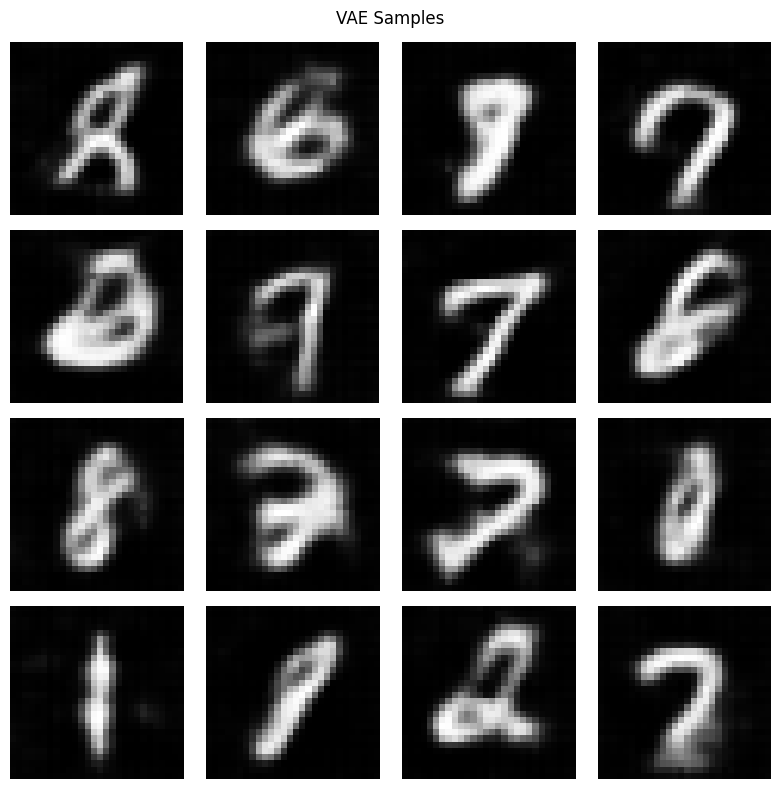

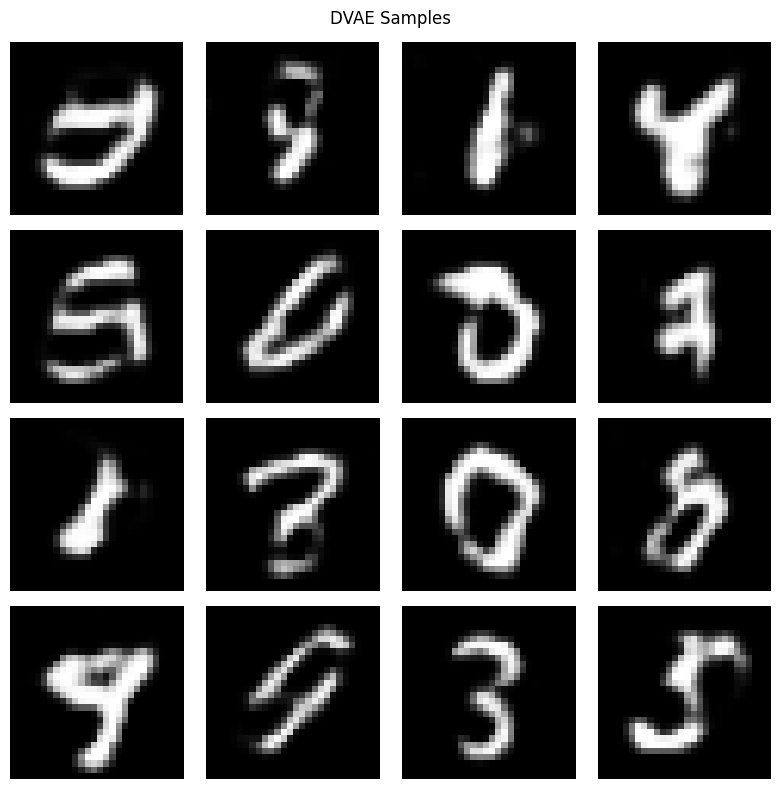

In [30]:
#Generate samples from VAE and DVAE
n_samples = 16

#VAE samples
vae_samples = vae_model.sample(n_samples, device)
fig_vae = visualize_generated_samples(vae_samples, num_examples=n_samples, grid_size=(4, 4), title='VAE Samples')

#DVAE samples
dvae_samples = dvae_model.sample(n_samples, device)
fig_dvae = visualize_generated_samples(dvae_samples, num_examples=n_samples, grid_size=(4, 4), title='DVAE Samples')
plt.show()


Encoding dataset: 100%|██████████| 157/157 [00:01<00:00, 83.26it/s] 
/home/rwelch/dvae4da/env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


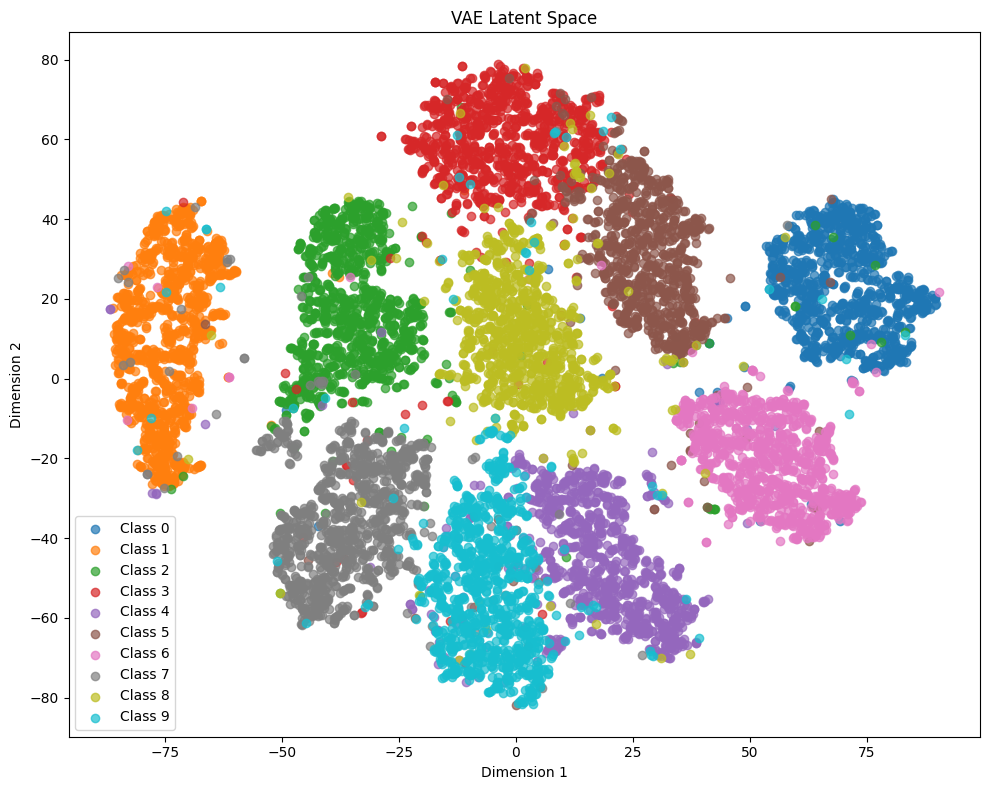

/home/rwelch/dvae4da/env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


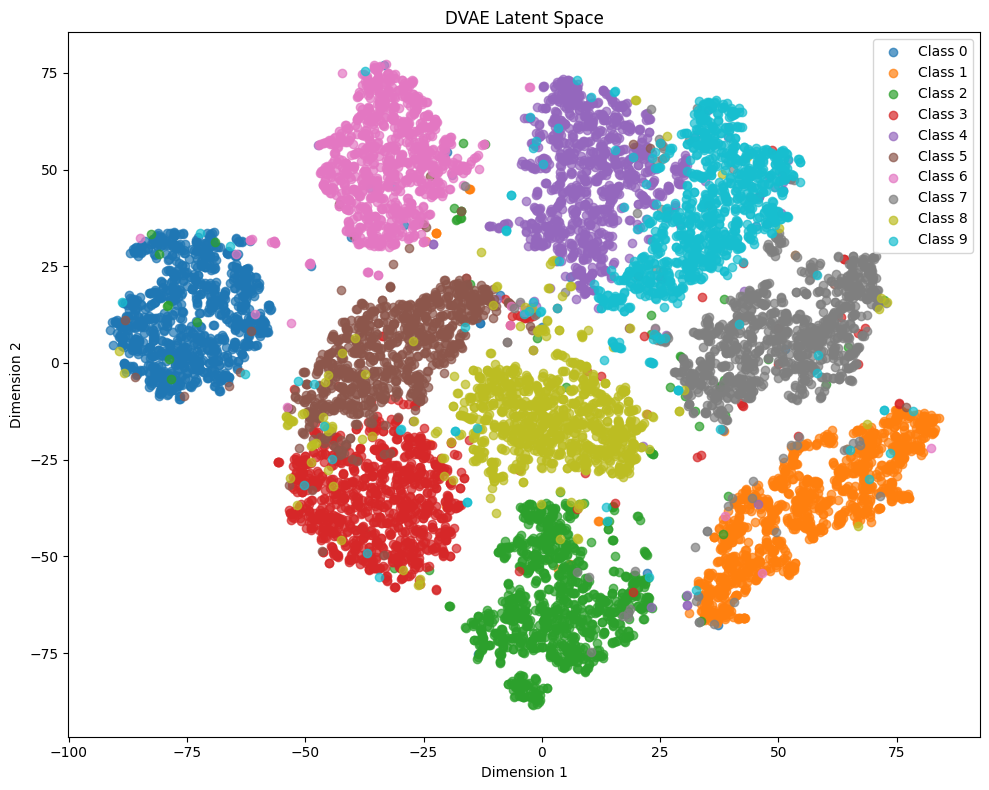

In [31]:
#Explore latent space
# Encode test dataset into latent space
vae_latent_codes, vae_labels = vae_trainer.encode_dataset(test_loader_clean)
dvae_latent_codes, dvae_labels = dvae_trainer.encode_dataset(test_loader_noisy)

# Visualize latent spaces using t-SNE
fig_vae_latent = visualize_latent_space(vae_latent_codes, vae_labels, method='tsne', perplexity=30, title='VAE Latent Space')
plt.savefig(os.path.join(save_dir, 'vae_latent_space.png'))
plt.show()

fig_dvae_latent = visualize_latent_space(dvae_latent_codes, dvae_labels, method='tsne', perplexity=30, title='DVAE Latent Space')
plt.savefig(os.path.join(save_dir, 'dvae_latent_space.png'))
plt.show()

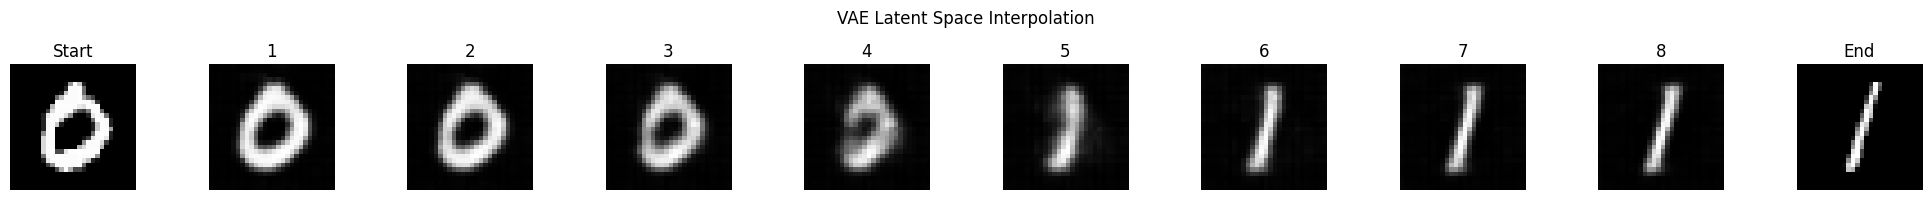

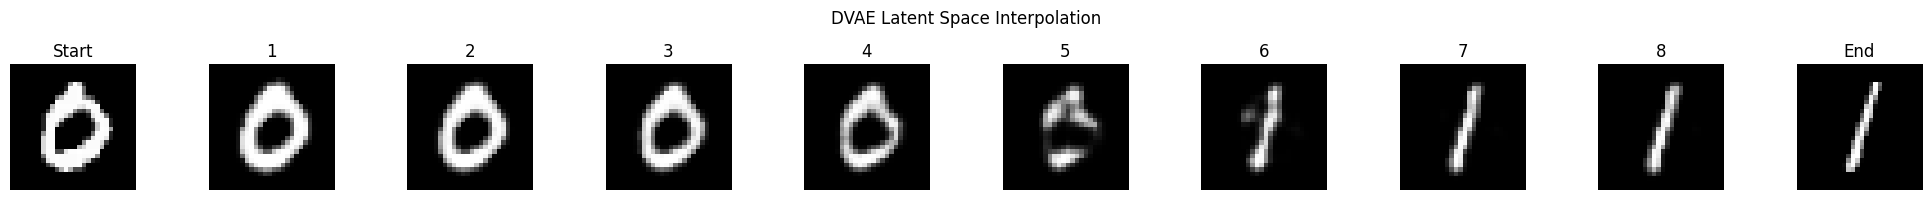

In [32]:
digit1_idx = 3  # Index of first digit (from test set)
digit2_idx = 2  # Index of second digit (from test set)

def interpolate_latent(model, img1, img2, n_steps=10, device=device):
    """Interpolate between two images in the latent space."""
    # Move images to device
    img1 = img1.unsqueeze(0).to(device)
    img2 = img2.unsqueeze(0).to(device)

    # Encode images to get latent vectors
    with torch.no_grad():
        z1, _ = model.encode(img1)
        z2, _ = model.encode(img2)

        alphas = torch.linspace(0, 1, n_steps).to(device)
        z_interp = torch.zeros(n_steps, z1.size(1)).to(device)

        for i, alpha in enumerate(alphas):
            z_interp[i] = (1 - alpha) * z1 + alpha * z2

        with torch.no_grad():
            x_interp = model.decode(z_interp)

        return x_interp, img1[0], img2[0]

# Get test images
batch = next(iter(test_loader_clean))
imgs, _ = batch
img1 = imgs[digit1_idx]
img2 = imgs[digit2_idx]

vae_interp, vae_img1, vae_img2 = interpolate_latent(vae_model, img1, img2, n_steps=8)
dvae_interp, dvae_img1, dvae_img2 = interpolate_latent(dvae_model, img1, img2, n_steps=8)

from src.utils.visualization import visualize_interpolation

fig_vae_interp = visualize_interpolation(
    vae_img1,
    vae_img2,
    vae_interp,
    title="VAE Latent Space Interpolation"
)
plt.savefig(os.path.join(save_dir, 'vae_interpolation.png'))
plt.show()

fig_dvae_interp = visualize_interpolation(
    dvae_img1,
    dvae_img2,
    dvae_interp,
    title="DVAE Latent Space Interpolation"
)
plt.savefig(os.path.join(save_dir, 'dvae_interpolation.png'))
plt.show()
